In [2]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pysm3
import pysm3.units as u
import pymaster as nmt
%matplotlib inline
#import packages

Using PySM3 to simulate foreground and cmb maps. The noise is simulated as a random process and linked to the noise sensitivity of Planck

In [3]:
#simulating foregroud emission and noise at the different Planck frequencies

nside = 128

npix = hp.nside2npix(nside)

# Planck frequencies (in GHz)
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0,  545.0,  857.0])
n_freqs = len(freqs)

# Planck noise sensitivity (in uK_arcmin)
sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])

#Importing models for foregrounds and cmb using pysm sky module

sky_d = pysm3.Sky(nside=nside, preset_strings=["d1"])
sky_s = pysm3.Sky(nside=nside, preset_strings=["s1"])
sky_f = pysm3.Sky(nside=nside, preset_strings=["f1"])
sky_cmb = pysm3.Sky(nside=nside, preset_strings=["c1"])

# Initialization of lists to collect maps of different components at different frequencies
noise_pl = []
dust_pl = []
sync_pl = []
ff_pl = []
cmb_pl =[]
for nf in range(n_freqs):
    #noise
    noise= (np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True))
    noise_pl.append(noise)
    #foregrounds
    dust= sky_d.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    dust_pl.append(dust)
    sync=sky_s.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))

    sync_pl.append(sync)
    ff=sky_f.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    ff_pl.append(ff)
    #cmb
    cmb = sky_cmb.get_emission(freqs[nf] * u.GHz)[0]* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    cmb_pl.append(cmb)


# Making lists numpy arrays. Their dimension is (N_freq,N_pixels).
noise_pl=np.array(noise_pl)
dust_pl=np.array(dust_pl)
sync_pl=np.array(sync_pl)
ff_pl=np.array(ff_pl)
cmb_pl = np.array(cmb_pl)


Combining the CMB and foreground maps to be input into ILC

In [4]:
maps_pl = cmb_pl + noise_pl + dust_pl + sync_pl + ff_pl #cmb and foregrounds combined

print(maps_pl.shape)

(9, 196608)


Transforimng frequency maps to harmonic space by decomposition

In [5]:
#transform maps to spherical harmonics
lmax=3*nside -1 #default is lmax= 3*nside+1
almsize=hp.Alm.getsize(lmax)
print(almsize)
print((lmax+1)**2)
print(lmax)
alm_maps=np.zeros((n_freqs, almsize), dtype=complex) #storing coefficients in an array of dim n_freqs*almsize. dtype is complex to account for -ive values

for nf in range(n_freqs):
    alm_maps[nf,:]= hp.map2alm(maps_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False) #record alm corresponding to each f for a corresponding l and m
    

73920
147456
383


Compute nf x nf Covariance matrix by fixing l for particular $a_{lm}$. Compute weights for every l
$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

In [6]:
C_l= np.zeros((lmax+1,n_freqs, n_freqs), dtype=float)#lmax+1 x freq x freq
for l in range(lmax+1):
    index= np.zeros((l+1), dtype=int) 
    for m in range(l+1):
        index[m]=hp.Alm.getidx(lmax, l,m) #getting indices corresponding to each l and m for m>0
    
   
    alm_p=alm_maps[:, index] #subarray of alm maps. : takes all values from first dim (frequencies). 2nd dim the values of m>0


    #alm = np.conj(alm_p) + alm_p #alm with positive and negative values

    C_l [l,:, :]= np.real(np.outer(alm_p[:, 0], alm_p[:,0])) #2d array from outer product alm_0
    
    for m in range(1,l+1): #sum over m
        C_l [l,:, :] += 2* np.real(np.outer(alm_p[:, m], np.conj(alm_p[:, m]))) #adding alm_p and negative ti C_l . outer product/multiplying over freq
C_l /= (2*l +1)   

print(alm_p.shape)
print(C_l.shape)

(9, 384)
(384, 9, 9)


Add a galaxy cut to get rid of emissions from the galactic plane. Create Mask

In [7]:
gal_cut = np.radians(10)
mask = np.zeros(npix, dtype=np.float32)
mask[hp.query_strip(nside, np.pi/2-gal_cut, np.pi/2+gal_cut)] = 1
mask[hp.query_disc(nside, hp.ang2vec(np.pi/2, 0), np.radians(20))] = 1
print(mask.shape)


(196608,)


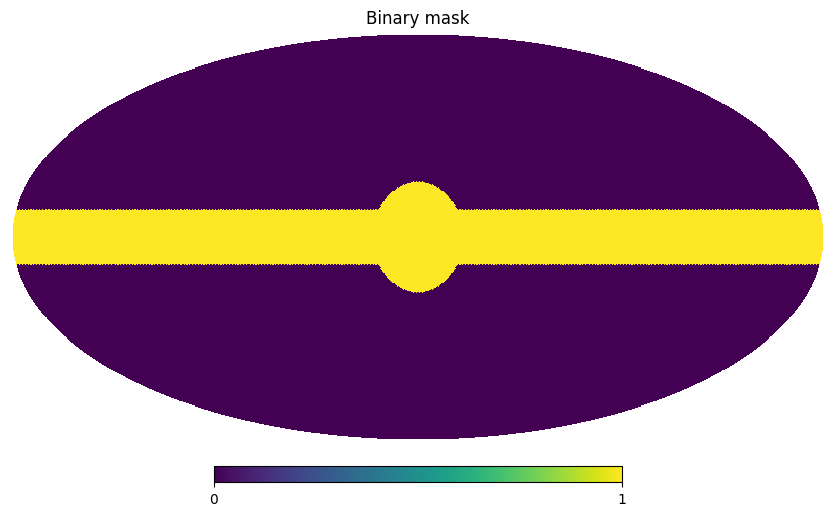

In [8]:
hp.mollview(mask, title="Binary mask")

Masking the combined maps

In [9]:
masked =np.zeros((n_freqs, npix))
masked =maps_pl[3,:] - maps_pl[3,:]*mask

#for nf in range(n_freqs):
 #   masked =maps_pl[nf,:] - maps_pl[nf,:]*mask
    #hp.mollview(masked, title='Masked map', min=-400, max=400)

Initializing field with mask

In [10]:
f_0 =nmt.NmtField(1-mask, [maps_pl[3,:]])

Defining the binning scheme.  how to group multipoles $\ell$ into bins. Here, the resolution is nside=128, and the bin width is 4 (i.e., each bin will group values of $\ell$ from 4 multipoles).

In [11]:
b = nmt.NmtBin.from_nside_linear(nside, 4)

In [12]:
#check= np.dot(b.T, b)

- obtain the **effective multipoles** $\ell$ associated with the bins in the binning scheme b from the NaMaster library.
- define which multipole $\ell$ values represent the center of each bin. The **effective multipoles** are typically the mean or central value of the multipoles within each bin. This helps to simplify the interpretation of the power spectra.
- array of **effective multipoles** $\ell$ for each bin.
- instead of plotting each individual $\ell$, you plot the effective $\ell$ of each bin, which is often more useful for interpreting power spectrum results.

In [13]:
ell_arr = b.get_effective_ells() 
print(ell_arr.shape) #lmax/4 number of bins

(95,)


In [14]:
cl_binned = b.bin_cell(C_l[:,3,3])
print(cl_binned.shape) #number of bins

(95,)


In [15]:
ls =np.arange(len(C_l[:,3,3]))
print(ls.shape)

(384,)


Pseudo C_l = C_l of masked map

In [16]:
#fsky = np.mean(f_0.get_mask()**2)
pcl = nmt.compute_coupled_cell(f_0,f_0)
#pcl_sky = nmt.compute_coupled_cell(f_0,f_0) /fsky
print(pcl.shape)

(1, 384)


Binned power spectrum C_b

The bin_cell function takes a power spectrum C_l  (provided as an array) and averages it into bins defined by the nmt.NmtBin object. Each bin corresponds to a range of multipole moments l and the function computes the mean value of C_l in each bin.

In [17]:
pcl_bin = b.bin_cell(pcl)
#pcl_bin_sky =b.bin_cell(pcl_sky)
print(pcl_bin.shape) #number of bins

(1, 95)


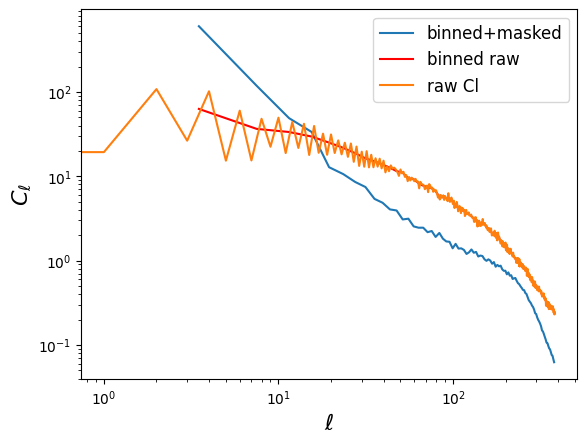

In [18]:
plt.plot(ell_arr, pcl_bin[0], label='binned+masked')
#plt.plot(ell_arr, pcl_bin_sky[0], label='normalised Pcl')
plt.plot(ell_arr, cl_binned, 'r', label='binned raw') 
plt.plot(ls, C_l[:,3,3], label='raw Cl')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(fontsize=12)
plt.show()


In [19]:
# - binning weights for each bandpower
n_bins = b.get_n_bands()
print(n_bins)

95


Mode Coupling Matrix $M_{bb'}$

(384, 384)
(95, 384)


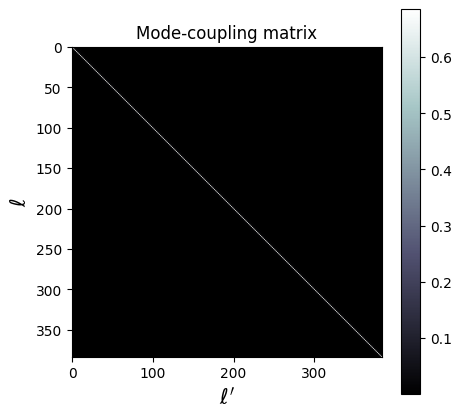

In [20]:
# Create a NaMaster workspace
w = nmt.NmtWorkspace.from_fields(f_0, f_0, b)

# Extract the mode-coupling matrix
mcm = w.get_coupling_matrix()
print(mcm.shape)

# Extract bandpower window functions
Wbl = w.get_bandpower_windows().squeeze()
print(Wbl.shape)

# Plot MCM
plt.figure(figsize=(5, 5))
plt.title('Mode-coupling matrix')
plt.imshow(mcm, cmap='bone')
plt.ylabel("$\\ell$", fontsize=15)
plt.xlabel("$\\ell'$", fontsize=15)
plt.colorbar()
plt.show()

Decoupled power spectra $C_l^* = M_{ll'}^{-1} \tilde{C}_l$

In [21]:
# First, estimated decoupled bandpowers. The explicit way of doing this would be to compute
# the binned PCL and the binned MCM. Then, invert the binned MCM, and multiply it by the PCL.
# All this can be done with a simple NaMaster call:
cl_dec = w.decouple_cell(pcl)
print(cl_dec.shape)

(1, 95)


*Alternate method*

Binned Pseudo Cl; $\tilde{C_b}= w_{bl}C_l$ 

Binned MCM; $M_{bb'}= w_{bl}M_{ll'} w_{bl}^T$ 

Decoupled power spectra $C_b^* = M_{bb'}^{-1} \tilde{C}_b$

In [22]:
mcm_binned_rows = np.array([b.bin_cell(row) for row in mcm])
mcm_binned = np.array([b.bin_cell(col) for col in mcm_binned_rows.T]).T*b.get_nell_list()
print(mcm_binned.shape)

(95, 95)


In [23]:
mcm_b_inv =np.linalg.pinv(mcm_binned)
print(mcm_b_inv.shape)

(95, 95)


In [24]:
bpw =np.einsum('jk,ik ->ij', mcm_b_inv, pcl_bin)
print(bpw.shape)
np.allclose(bpw,cl_dec)

(1, 95)


True

In [25]:
cl_00 = nmt.compute_full_master(f_0, f_0, b)
print(cl_00.shape)

(1, 95)


In [26]:
mean=np.mean(1-mask)

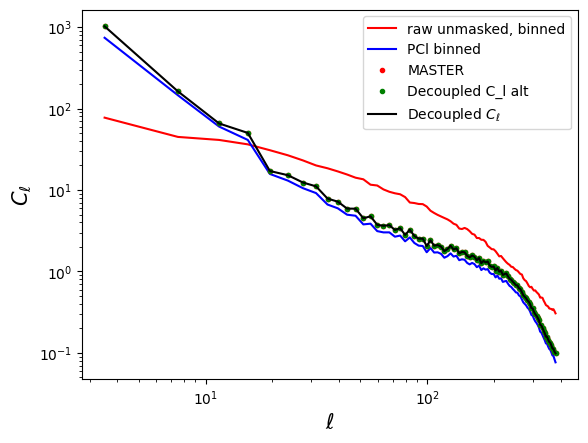

In [30]:
plt.plot(ell_arr, cl_binned/mean, 'r-', label='raw unmasked, binned')
plt.plot(ell_arr, pcl_bin[0]/mean, 'b-',label='PCl binned')
plt.plot(ell_arr, cl_00[0]/mean, 'r.', label='MASTER' )
#plt.plot(ls, pcl[0], 'g',label='PCl unbinned')
plt.plot(ell_arr, bpw[0,:]/mean, 'g.', label='Decoupled C_l alt')
plt.plot(ell_arr, cl_dec[0]/mean, 'k-', label=r'Decoupled $C_\ell$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=10)
plt.show()